In [2]:
%matplotlib inline

import pymc3 as pm

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import mode

import theano

# One good, one bad

We have two sensors, `S1` and `S2`.

`S1` has very low bias and very low absolute error, but it is also very expensive to sample from (perhaps it requires an actual human to come in and do the measurements).

`S2` has unknown bias and unknown error rate, but it is very fast and cheap.

Our goal is to infer the real values as accurately as possible and to find `S2`'s bias and error rate.

In [115]:
REAL_AVG    = 10
REAL_STD    = 3

FIRST_STD   = 0
FIRST_BIAS  = 0
FIRST_PROB  = 0.1

SECOND_STD  = 2
SECOND_BIAS = 2
N_POINTS    = 100

RNG = np.random.RandomState(42)
unobserved_real_values = RNG.normal(size=N_POINTS) * REAL_STD + REAL_AVG

x1_mask = RNG.uniform(size=N_POINTS) >= FIRST_PROB
x1 = np.ma.masked_array(RNG.normal(size=N_POINTS) * FIRST_STD + unobserved_real_values + FIRST_BIAS, x1_mask)
x2 = RNG.normal(size=N_POINTS) * SECOND_STD + unobserved_real_values + SECOND_BIAS

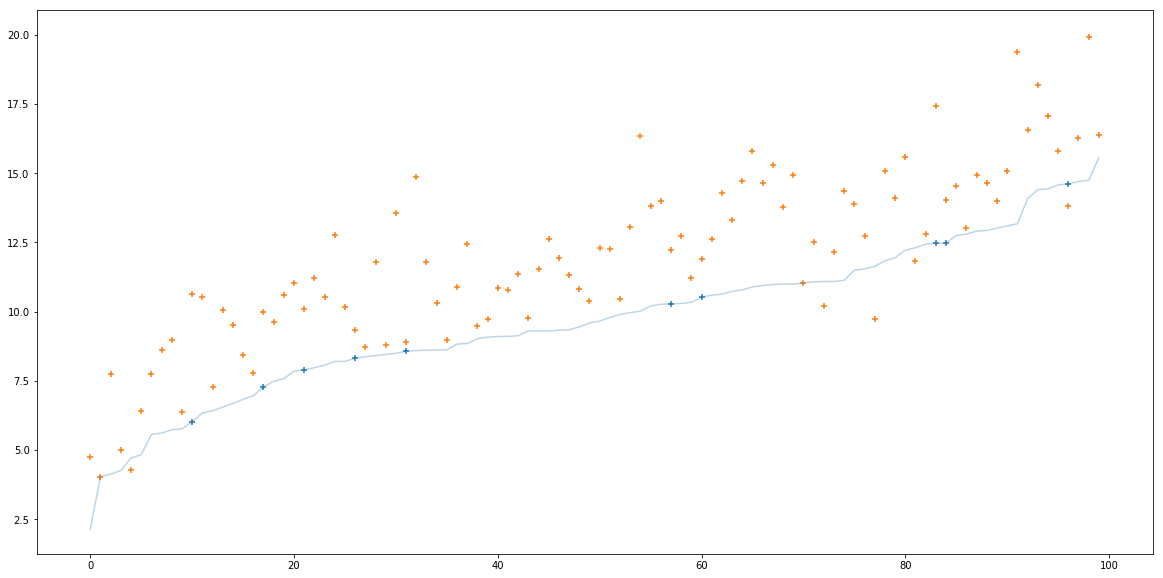

In [141]:
SORTED = True

plt.figure(figsize=(20, 10))
sorting = np.argsort(unobserved_real_values) if SORTED else np.arange(N_POINTS)
plt.plot(np.arange(N_POINTS), unobserved_real_values[sorting], alpha=0.3)
plt.scatter(np.arange(N_POINTS), x1[sorting], marker='+')
plt.scatter(np.arange(N_POINTS), x2[sorting], marker='+');

In [117]:
with pm.Model() as model_robust:
    x0_sigma = pm.HalfCauchy('x0_sigma', beta=20, testval=1)
    x0_bias  = pm.Normal('x0_bias', 0, sigma=20, testval=1)
    x0_v     = pm.Normal('x0_v', x0_bias, sigma=x0_sigma, shape=x2.shape, observed=x1)
    
    # x1_sigma = pm.HalfCauchy('x1_sigma', beta=0.1, testval=1)
    x2_sigma = pm.HalfCauchy('x2_sigma', beta=4, testval=1)
    x2_bias  = pm.Normal('x2_bias', 0, sigma=4, testval=1)
    
    # x1_v = pm.Normal('x1_v', x0_v, sigma=x1_sigma, observed=x1)
    x2_v = pm.Normal('x2_v', x0_v + x2_bias, sigma=x2_sigma, observed=x2)
    
    trace_robust = pm.sample(10000,
                             random_seed=17, tune=1000,
                             nuts_kwargs={'target_accept': 0.9})

/usr/local/lib/python3.7/site-packages/pymc3/model.py:1331: UserWarning: Data in x0_v contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, UserWarning)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x2_bias, x2_sigma, x0_v_missing, x0_bias, x0_sigma]
Sampling 4 chains: 100%|██████████| 44000/44000 [00:54<00:00, 814.58draws/s] 
The number of effective samples is smaller than 25% for some parameters.


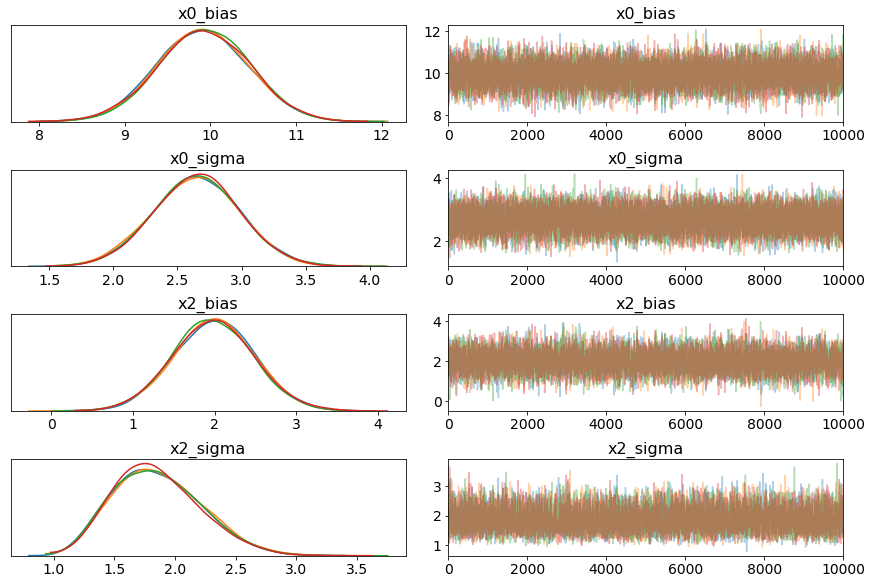

In [118]:
pm.traceplot(trace_robust, var_names=['x0_bias', 'x0_sigma', 'x2_bias', 'x2_sigma']);

In [119]:
print(trace_robust.varnames)
print(trace_robust['x0_v_missing'].shape)

['x0_sigma_log__', 'x0_bias', 'x0_v_missing', 'x2_sigma_log__', 'x2_bias', 'x0_sigma', 'x2_sigma']
(40000, 90)


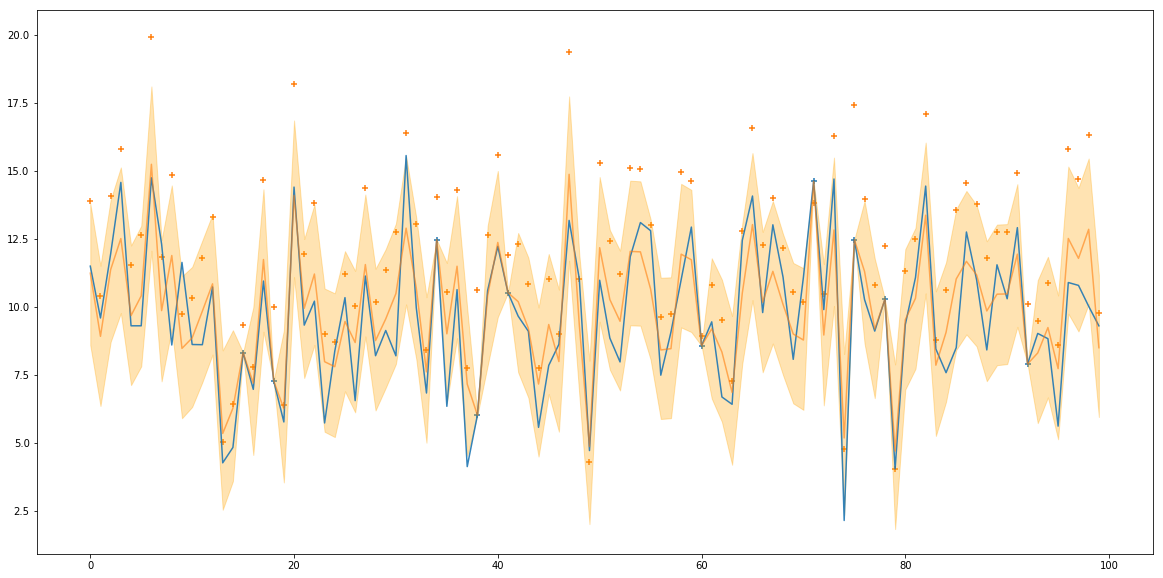

In [143]:
SORTED = False

sorting = np.argsort(unobserved_real_values) if SORTED else np.arange(N_POINTS)

predicted_real_values = np.zeros(N_POINTS)
predicted_real_values[x1_mask] = trace_robust['x0_v_missing'].mean(axis=0)
predicted_real_values[~x1_mask] = unobserved_real_values[~x1_mask]

predicted_real_values_lower = np.zeros(N_POINTS)
predicted_real_values_lower[x1_mask] = np.quantile(trace_robust['x0_v_missing'], 0.05, axis=0)
predicted_real_values_lower[~x1_mask] = unobserved_real_values[~x1_mask]

predicted_real_values_upper = np.zeros(N_POINTS)
predicted_real_values_upper[x1_mask] = np.quantile(trace_robust['x0_v_missing'], 0.95, axis=0)
predicted_real_values_upper[~x1_mask] = unobserved_real_values[~x1_mask]

plt.figure(figsize=(20, 10))
plt.plot(np.arange(N_POINTS), unobserved_real_values[sorting], alpha=0.9)
plt.scatter(np.arange(N_POINTS), x1[sorting], marker='+')
plt.scatter(np.arange(N_POINTS), x2[sorting], marker='+')
plt.plot(np.arange(N_POINTS), predicted_real_values[sorting], alpha=0.6)
plt.fill_between(np.arange(N_POINTS), predicted_real_values_lower[sorting], predicted_real_values_upper[sorting], alpha=0.3, color='orange');

# Multiple biased sensors

Sensor 0:
  Bias   = 0.05
  Noise  = 0.51
  Avail. = 0.27
Sensor 1:
  Bias   = 1.74
  Noise  = 0.09
  Avail. = 0.74
Sensor 2:
  Bias   = -0.88
  Noise  = 0.15
  Avail. = 0.34
Sensor 3:
  Bias   = 0.08
  Noise  = 0.65
  Avail. = 0.64
Sensor 4:
  Bias   = 0.45
  Noise  = 0.45
  Avail. = 0.62


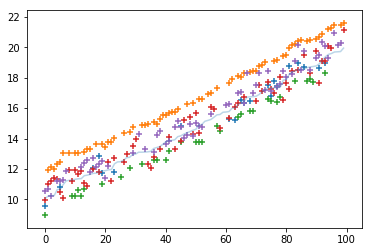

In [191]:
RNG = np.random.RandomState(1515)

N_SENSORS      = 5  # The number of sensors
N_MEASUREMENTS = 100 # The number of measurements

REAL_AVG    = 10 # The real temperature average
REAL_STD    = 10 # Temperature range 

SENSOR_BIAS = RNG.normal(size=N_SENSORS) * 1   # Sensor biases.
SENSOR_STD  = np.abs(RNG.normal(size=N_SENSORS)) * 0.5 # Sensor error.
SENSOR_PROB = RNG.beta(3, 3, size=N_SENSORS)   # Sensor availability rate.

for i, (sb, sn, sp) in enumerate(zip(SENSOR_BIAS, SENSOR_STD, SENSOR_PROB)):
    print("Sensor %d:" % i)
    print("  Bias   = %.2f" % sb)
    print("  Noise  = %.2f" % sn)
    print("  Avail. = %.2f" % sp)

unobserved_real_values = RNG.uniform(size=N_POINTS) * REAL_STD + REAL_AVG

sensor_values = unobserved_real_values[None, :] + \
    SENSOR_BIAS[:,None] + \
    RNG.normal(size=(N_SENSORS, N_POINTS)) * SENSOR_STD[:, None]

sensor_masks = RNG.uniform(size=(N_SENSORS, N_POINTS)) >= SENSOR_PROB[:,None]
sensor_masks[np.argmax(SENSOR_PROB), sensor_masks.sum(axis=0) == 0] = True
assert np.all(sensor_masks.sum(axis=0) != 0)

# print(np.logical_or(sensor_masks, axis=1))
sensor_values = np.ma.masked_array(sensor_values, sensor_masks)

SORTED = True
sorting = np.argsort(unobserved_real_values) if SORTED else np.arange(N_POINTS)
plt.plot(np.arange(N_POINTS), unobserved_real_values[sorting], alpha=0.3)
for i in range(N_SENSORS):
    plt.scatter(np.arange(N_POINTS), sensor_values[i,sorting], marker='+')

In [193]:
with pm.Model() as model:
    real_range  = pm.HalfCauchy('real_range', beta=20, testval=1)
    real_mean   = pm.Normal('real_mean', 0, sigma=20, testval=1)
    real_values = pm.Normal('x0_v', real_mean, sigma=real_range, shape=[N_POINTS], testval=np.ones(N_POINTS))
    # real_values = pm.Flat('x0_v', shape=[N_POINTS], testval=np.ones(N_POINTS))
    
    p_sensor_sigma  = pm.HalfCauchy('sensor_sigma', beta=1, shape=[N_SENSORS], testval=np.ones(N_SENSORS))
    p_sensor_bias   = pm.Normal('sensor_bias', 0, sigma=1, shape=[N_SENSORS], testval=np.ones(N_SENSORS))
    
    p_sensor_offsets = pm.Normal(
        'sensor_offsets', real_values[None,:] + p_sensor_bias[:, None], sigma=p_sensor_sigma[:, None], 
        observed=sensor_values, shape=[N_SENSORS, N_POINTS])
    
#     advi = pm.ADVI()
#     approx = advi.fit(n=200000)
    
    trace = pm.sample(1000, tune=1000, cores=4, init='advi',
                      random_seed=17,
                      nuts_kwargs={'target_accept': 0.93})

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average Loss = 899.9:  28%|██▊       | 56211/200000 [00:37<01:35, 1504.60it/s]  
Convergence achieved at 56300
Interrupted at 56,299 [28%]: Average Loss = 2,738.5
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sensor_offsets_missing, sensor_bias, sensor_sigma, x0_v, real_mean, real_range]
Sampling 4 chains: 100%|██████████| 8000/8000 [10:26<00:00, 12.77draws/s]  
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The acceptance probability does not match the target. It is 0.6922218069849856, but should be close to 0.93. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The acceptance probability does not match the target. It is 0.8357599399675156, but should be close to 0.93. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Incr

array([<matplotlib.axes._subplots.AxesSubplot object at 0x12a5550d0>,
      dtype=object)

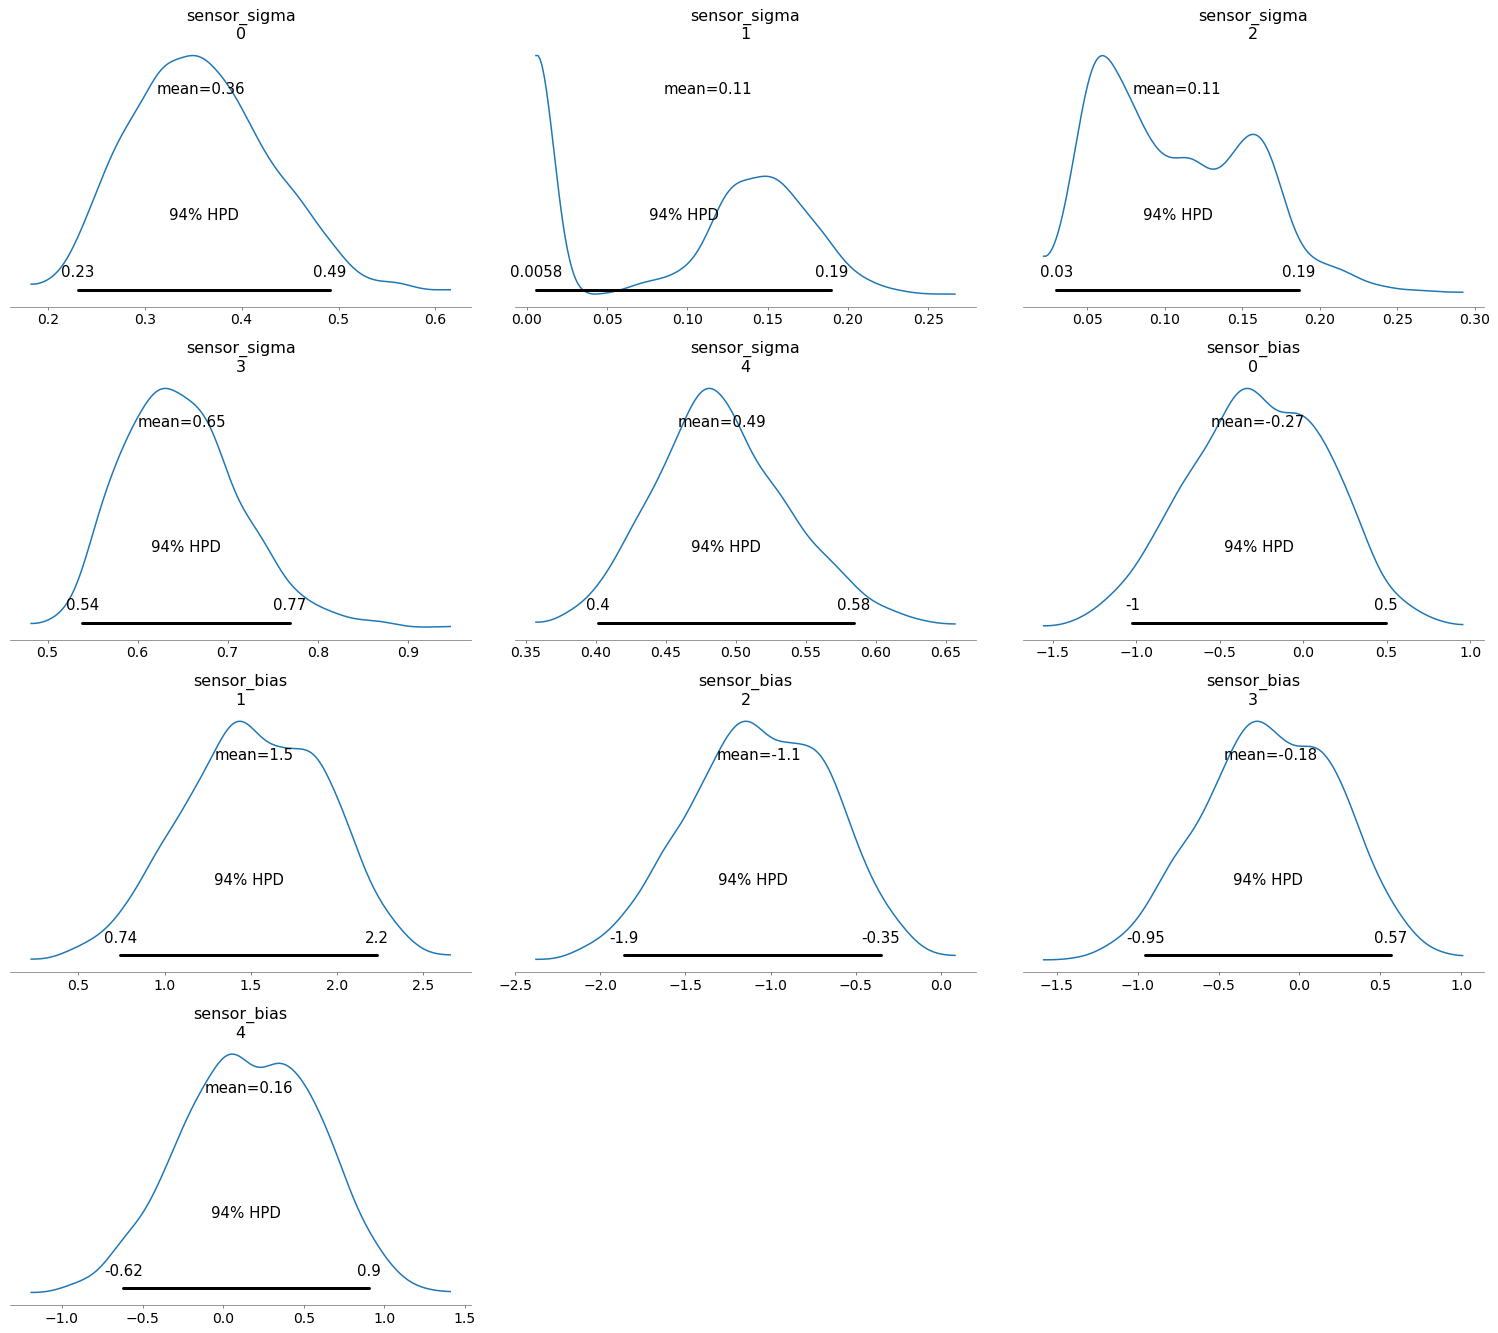

In [194]:
pm.plot_posterior(trace, var_names=['sensor_sigma', 'sensor_bias'])

In [179]:
print(trace.varnames)

['real_range_log__', 'real_mean', 'x0_v', 'sensor_sigma_log__', 'sensor_bias', 'real_range', 'sensor_sigma']


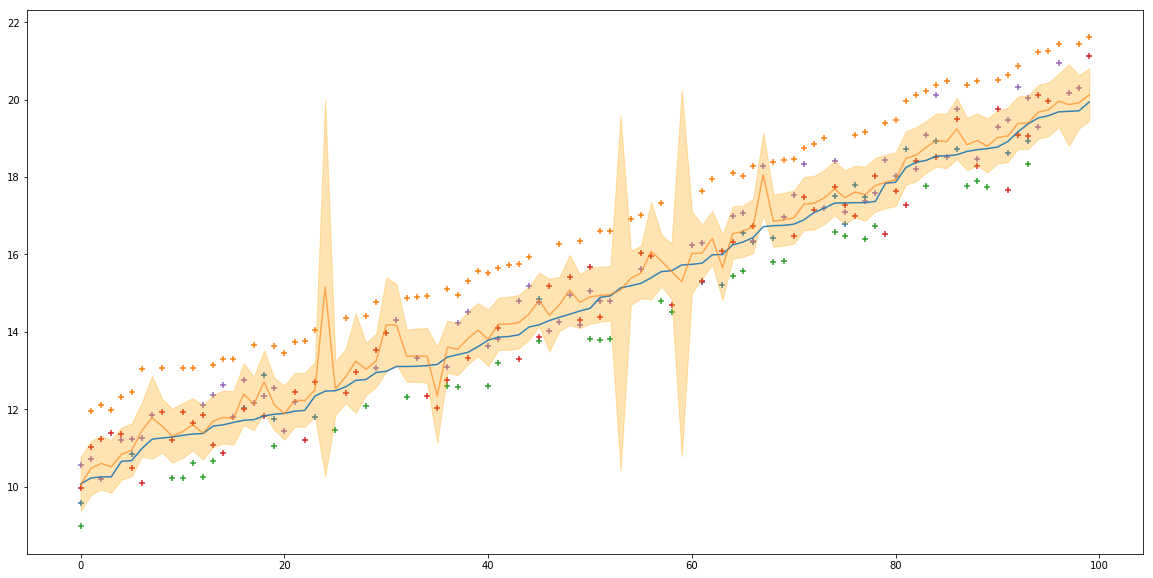

In [195]:
SORTED = True

sorting = np.argsort(unobserved_real_values) if SORTED else np.arange(N_POINTS)

predicted_real_values = trace['x0_v'].mean(axis=0)
predicted_real_values_lower = np.quantile(trace['x0_v'], 0.05, axis=0)
predicted_real_values_upper = np.quantile(trace['x0_v'], 0.95, axis=0)

plt.figure(figsize=(20, 10))
plt.plot(np.arange(N_POINTS), unobserved_real_values[sorting], alpha=0.9)
for i in range(N_SENSORS):
    plt.scatter(np.arange(N_POINTS), sensor_values[i,sorting], marker='+')

plt.plot(np.arange(N_POINTS), predicted_real_values[sorting], alpha=0.6)
plt.fill_between(np.arange(N_POINTS), predicted_real_values_lower[sorting], predicted_real_values_upper[sorting], alpha=0.3, color='orange');